In [3]:
import sys

sys.path.append("../..")
from collections import defaultdict

import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader


from ensemblecalibration.calibration.test_objectives import skce_ul_obj, skce_ul_obj_new
from ensemblecalibration.calibration.minimization import (
    solve_cobyla2D,
    solve_cobyla1D,
    solve_pyswarm,
)
from ensemblecalibration.calibration.experiments import (
    experiment_h0,
    experiment_h0_feature_dependency,
    experiment_h1,
)
from ensemblecalibration.nn_training.train import train_mlp, get_optim_lambda_mlp
from ensemblecalibration.nn_training.model import DirichletDataset
from ensemblecalibration.nn_training.losses import SKCELoss
from ensemblecalibration.nn_training.distances import tv_distance_tensor
from ensemblecalibration.calibration.config import (
    config_tests_cobyla_1d,
    config_tests_cobyla_2d,
)
 

### test settings of experiments

In [5]:
# parameters
M = 10
K = 10
N = 1000
u = 0.1
# MLP parameters
N_EPOCHS = 100
LR = 0.001
BATCH_SIZE = 128


### initialize datasets and dataloaders

In [10]:
dataset_train = DirichletDataset(n_samples=N, n_members=M, n_classes=K, u_s=u)
dataset_val = DirichletDataset(n_samples=1000, n_members=M, n_classes=K, u_s=u)

loader_train = DataLoader(dataset_train, shuffle=True, batch_size=BATCH_SIZE)
loader_val = DataLoader(dataset_val, shuffle=True, batch_size=len(dataset_val))

In [11]:
loss_skce = SKCELoss(dist_fct=tv_distance_tensor)

weights_model = get_optim_lambda_mlp(dataset_train=dataset_train, loss=loss_skce, n_epochs=10)

In [9]:
optim_weights = dataset_train.optim_weights
print(f'Difference: {(optim_weights -weights_model.detach().numpy()).sum()}')

Difference: -4.24683088084965e-07


### difference predicted weights vs optimal weights

In [28]:
optim_weights = dataset_train.optim_weights
(optim_weights - weights_model.detach().numpy()).sum()

-3.299608429330192e-05

### Comparison with Cobyla method

In [14]:
weights_cobyla, stats = solve_cobyla2D(dataset_train.p_probs, y_train, params=config_tests_cobyla_2d["SKCEul"]["params"], enhanced_output=True)

In [15]:
weights_cobyla.reshape(1000, -1)

array([[0.1, 0.1, 0.1, ..., 0.1, 0.1, 0.1],
       [0.1, 0.1, 0.1, ..., 0.1, 0.1, 0.1],
       [1.1, 1.1, 1.1, ..., 1.1, 1.1, 1.1],
       ...,
       [0.1, 0.1, 0.1, ..., 0.1, 0.1, 0.1],
       [0.1, 0.1, 0.1, ..., 0.1, 0.1, 0.1],
       [0.1, 0.1, 0.1, ..., 0.1, 0.1, 0.1]])

In [ ]:
p_train, y_train, optim_weights = experiment_h0_feature_dependency(N, M, K, u, return_optim_weight=True)
p_val, y_val = experiment_h0_feature_dependency(M, M, K, u)

loss = SKCELoss(dist_fct=tv_distance_tensor)
loss_real = skce_ul_obj_new(optim_weights, p_train, y_train, params=config_tests_cobyla_2d["SKCEul"]["params"])
loss_real

8.59419343058693e-05

### Test different minimization methods on  setting where optimal lambda is known

#### initialize experiments

In [ ]:
p_train_nn = torch.from_numpy(p_train).float()
p_val_nn = torch.from_numpy(p_val).float()
y_train_nn = torch.from_numpy(y_train)
y_val_nn = torch.from_numpy(y_val)

model = train_mlp(p_train=p_train_nn, y_train=y_train_nn, p_val=p_val_nn, y_val=y_val_nn,
                   loss=loss, n_epochs=N_EPOCHS,lr=LR)

/Users/mirajuergens/Library/CloudStorage/OneDrive-UGent/Code/EnsembleCalibration/ensemblecalibration/nn_training/model.py:37: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  out = self.softmax(out)


Epoch: 0 loss: 9.36581212584997e-09
Epoch: 1 loss: 9.353104069020901e-09
Epoch: 2 loss: 9.340485718212221e-09
Epoch: 3 loss: 9.327734140640587e-09
Epoch: 4 loss: 9.315082927230378e-09
Epoch: 5 loss: 9.302477899097994e-09


KeyboardInterrupt: 

In [ ]:
weights_model = model[0](p_train_nn)

weights_model.sum(1).shape

torch.Size([1000])

In [ ]:
optim_weights-weights_model.detach().numpy().sum()

array([[ -999.99999998,  -999.99941402,  -999.98301622, ...,
         -999.20748331,  -999.98506639,  -999.99998661],
       [ -999.99999937,  -999.99990745,  -999.99523314, ...,
         -999.86076044,  -999.19923495,  -999.99999998],
       [ -999.99999998,  -999.99739844,  -999.99998037, ...,
         -999.99969231,  -999.98970477,  -999.01847667],
       ...,
       [ -999.99850712, -1000.        ,  -999.91363401, ...,
        -1000.        ,  -999.99999904,  -999.99773174],
       [ -999.999995  , -1000.        ,  -999.98878072, ...,
         -999.99999999,  -999.23060126,  -999.9997793 ],
       [-1000.        ,  -999.99999514,  -999.77684484, ...,
         -999.92161577,  -999.99999999,  -999.99999994]])

In [ ]:
weights_cobyla, stats = solve_cobyla2D(p_train, y_train, params=config_tests_cobyla_2d["SKCEul"]["params"], enhanced_output=True)

In [ ]:
weights_cobyla.reshape(1000,-1)

array([[1.1, 1.1, 1.1, ..., 1.1, 1.1, 1.1],
       [0.1, 0.1, 0.1, ..., 0.1, 0.1, 0.1],
       [1.1, 1.1, 1.1, ..., 1.1, 1.1, 1.1],
       ...,
       [0.1, 0.1, 0.1, ..., 0.1, 0.1, 0.1],
       [0.1, 0.1, 0.1, ..., 0.1, 0.1, 0.1],
       [0.1, 0.1, 0.1, ..., 0.1, 0.1, 0.1]])

In [ ]:
optim_weights - weights_model.detach().numpy()

array([[-0.09687563, -0.06493955, -0.09265947, ..., -0.09771534,
         0.5746057 , -0.09771955],
       [-0.08604969, -0.08843713, -0.0856195 , ...,  0.03424667,
         0.00104901, -0.08848387],
       [-0.11730285, -0.1178821 , -0.09433331, ..., -0.0858184 ,
        -0.105301  , -0.11580221],
       ...,
       [-0.10504118,  0.12506311, -0.11442448, ..., -0.09621526,
        -0.11406293, -0.11324694],
       [-0.06526196,  0.77341256, -0.10465325, ..., -0.10638508,
        -0.10568383, -0.025973  ],
       [-0.0860023 , -0.05048491,  0.22403939, ..., -0.03384521,
        -0.09666237, -0.09658354]])

### initialize the experiment: calculate P matrix for case where mdoel is calibrated and case where it is not

In [ ]:
P_0, y_0 = experiment_h0(N=100, M=10, K=10, u=0.01)
P_1, y_1 = experiment_h1(N=100, M=10, K=10, u=0.01)

/Users/mirajuergens/Library/CloudStorage/OneDrive-UGent/Code/EnsembleCalibration/ensemblecalibration/calibration/iscalibrated.py:27: OptimizeWarning: A_eq does not appear to be of full row rank. To improve performance, check the problem formulation for redundant equality constraints.
  lp = linprog(c, A_eq=A, b_eq=b)
/Users/mirajuergens/opt/miniconda3/envs/calibration/lib/python3.8/site-packages/scipy/optimize/_linprog_util.py:681: RuntimeWarning: overflow encountered in double_scalars
  val = b_eq[row] / A_eq[row, col]
/Users/mirajuergens/opt/miniconda3/envs/calibration/lib/python3.8/site-packages/scipy/optimize/_linprog_util.py:731: RuntimeWarning: invalid value encountered in subtract
  i_f = np.abs(lb - ub) < tol   # indices of "fixed" variables


In [ ]:
# number of iterations for calculating the minimum
N_ITERS = 100

In [ ]:
def test_minimization(params_tests, min_fct, experiment=experiment_h0, n_iters: int = 100):
    """test for estimating teh distribution of approximated minimal calibration measures using a predefined method and calibration bojective 

    Parameters
    ----------
    params_tests : dict
        test parameters
    min_fct : _type_
        function for solving the minimization problem. Takes as input arguments the tensor of point predictions P,
        the array of labels y the test parameters and an optional boolean whether the minimal value shall also be output
    experiment : _type_, optional
        experiment which yields a tensor P and labels y used for calculating the minima, by default experiment_h0
    n_iters : int, optional
        number of times the distribution is sampled from and the minima are calculated, by default 100

    Returns
    -------
    _type_
        _description_
    """

    list_stats = {}
    for test in params_tests:
        list_stats[test] = []
    for i in range(n_iters):
        print(f'start {i}-th iteration...')
        P, y = experiment(N=100, M=10, K=10, u=0.01)
        for test in params_tests:
            conf = params_tests[test]
            weights_l, min_stat = min_fct(P, y, conf["params"], enhanced_output=True)
            list_stats[test].append(min_stat)
        


    return list_stats


In [ ]:
res_cobyla1d = test_minimization(config_tests, min_fct=solve_cobyla1D, experiment=experiment_h0)

res_cobyla1d

/Users/mirajuergens/Library/CloudStorage/OneDrive-UGent/Code/EnsembleCalibration/ensemblecalibration/calibration/calibration_measures.py:138: RuntimeWarning: invalid value encountered in double_scalars
  dev_bk = ((o_bk-p_bk)**2)/p_bk


{'HL5': [19.654895726377227,
  27.65078320849503,
  13.195520675534006,
  14.997547336517624,
  26.22709013830734,
  14.32140049998662,
  21.14785566037347,
  40.16081343187511,
  24.19270247794368,
  20.222875642093882,
  25.011880092380178,
  11.617155059578081,
  20.0008919131728,
  21.714196615093083,
  19.84130324884676,
  18.918311169701088,
  22.86350243357265,
  24.458955309256133,
  18.288708225916036,
  17.850489057093554,
  19.411422276637847,
  19.612883240152797,
  18.1983751398011,
  17.125463114865294,
  19.370166763725006,
  19.799531392619084,
  19.404488595565606,
  22.462072395077357,
  22.086043197817368,
  22.52861632440923,
  22.820587574347396,
  18.232414850407753,
  25.67566086324496,
  22.056333986192627,
  33.14236632094429,
  14.38509207310128,
  27.39447312113458,
  53.12624146356169,
  13.526344312463577,
  14.732725658071262,
  17.71533494232638,
  17.888606162231422,
  20.447719295450664,
  15.694267280010138,
  32.780732885364046,
  18.561707344794215,


In [ ]:
res_cobla2d = test_minimization(config_tests_new, min_fct=solve_cobyla2D, experiment=experiment_h0)

start 0-th iteration...
start 1-th iteration...
start 2-th iteration...
start 3-th iteration...
start 4-th iteration...
start 5-th iteration...
start 6-th iteration...
start 7-th iteration...
start 8-th iteration...
start 9-th iteration...


/Users/mirajuergens/Library/CloudStorage/OneDrive-UGent/Code/EnsembleCalibration/ensemblecalibration/calibration/calibration_measures.py:138: RuntimeWarning: invalid value encountered in double_scalars
  dev_bk = ((o_bk-p_bk)**2)/p_bk


start 10-th iteration...
start 11-th iteration...
start 12-th iteration...
start 13-th iteration...
start 14-th iteration...
start 15-th iteration...
start 16-th iteration...
start 17-th iteration...
start 18-th iteration...
start 19-th iteration...
start 20-th iteration...
start 21-th iteration...
start 22-th iteration...
start 23-th iteration...
start 24-th iteration...
start 25-th iteration...
start 26-th iteration...
start 27-th iteration...
start 28-th iteration...
start 29-th iteration...
start 30-th iteration...
start 31-th iteration...
start 32-th iteration...
start 33-th iteration...
start 34-th iteration...
start 35-th iteration...
start 36-th iteration...
start 37-th iteration...
start 38-th iteration...
start 39-th iteration...
start 40-th iteration...
start 41-th iteration...
start 42-th iteration...
start 43-th iteration...
start 44-th iteration...
start 45-th iteration...
start 46-th iteration...
start 47-th iteration...
start 48-th iteration...
start 49-th iteration...


{'HL5': [19.654895726377227,
  27.65078320849503,
  13.195520675534006,
  14.997547336517624,
  26.22709013830734,
  14.32140049998662,
  21.14785566037347,
  40.16081343187511,
  24.19270247794368,
  20.222875642093882,
  25.011880092380178,
  11.617155059578081,
  20.0008919131728,
  21.714196615093083,
  19.84130324884676,
  18.918311169701088,
  22.86350243357265,
  24.458955309256133,
  18.288708225916036,
  17.850489057093554,
  19.411422276637847,
  19.612883240152797,
  18.1983751398011,
  17.125463114865294,
  19.370166763725006,
  19.799531392619084,
  19.404488595565606,
  22.462072395077357,
  22.086043197817368,
  22.52861632440923,
  22.820587574347396,
  18.232414850407753,
  25.67566086324496,
  22.056333986192627,
  33.14236632094429,
  14.38509207310128,
  27.39447312113458,
  53.12624146356169,
  13.526344312463577,
  14.732725658071262,
  17.71533494232638,
  17.888606162231422,
  20.447719295450664,
  15.694267280010138,
  32.780732885364046,
  18.561707344794215,


### plot results in histograms

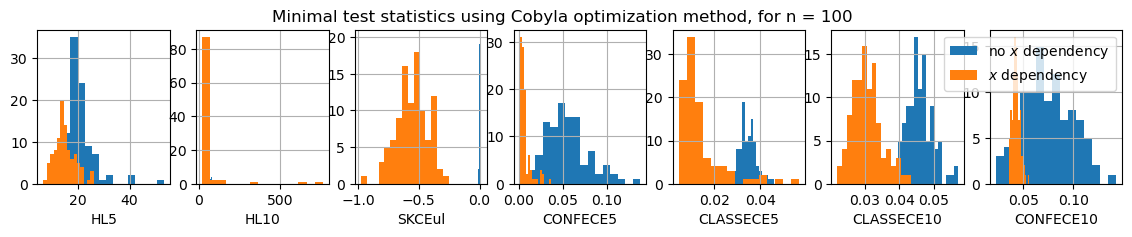

In [ ]:
fig, ax = plt.subplots(1, len(config_tests), figsize=(14, 2))

for i, test in enumerate(config_tests):
    ax[i].hist(res_cobyla1d[test], bins=15, label="no $x$ dependency")
    ax[i].set_xlabel(test)
    ax[i].grid()

for i, test in enumerate(config_tests_new):
    ax[i].hist(res_cobla2d[test], bins=15, label="$x$ dependency")

plt.legend()
plt.suptitle(f'Minimal test statistics using Cobyla optimization method, for n = {N_ITERS}')
plt.show()

In [ ]:
res_cobyla2d = test_minimization(config_tests_new, min_fct=solve_cobyla2D, P=P_0, y=y_0)

res_cobyla2d

{'HL5': 11.41002238895083,
 'HL10': 24.97340694820906,
 'SKCEul': -0.42865073912068824,
 'ECEconf5': 0.004988531551112228,
 'ECEconf10': 0.005378983338117513,
 'ECEclass5': 0.02586380124921605,
 'ECEclass10': 0.03967081019347045}

In [ ]:
res_pyswarm = test_minimization(config_tests_new, min_fct=solve_pyswarm, P=P_0, y=y_0)

Stopping search: maximum iterations reached --> 100
However, the optimization couldn't find a feasible design. Sorry


/Users/mirajuergens/Library/CloudStorage/OneDrive-UGent/Code/EnsembleCalibration/ensemblecalibration/calibration/calibration_measures.py:138: RuntimeWarning: invalid value encountered in double_scalars
  dev_bk = ((o_bk-p_bk)**2)/p_bk


Stopping search: maximum iterations reached --> 100
However, the optimization couldn't find a feasible design. Sorry
Stopping search: maximum iterations reached --> 100
However, the optimization couldn't find a feasible design. Sorry
Stopping search: maximum iterations reached --> 100
However, the optimization couldn't find a feasible design. Sorry
Stopping search: maximum iterations reached --> 100
However, the optimization couldn't find a feasible design. Sorry
Stopping search: maximum iterations reached --> 100
However, the optimization couldn't find a feasible design. Sorry
Stopping search: maximum iterations reached --> 100
However, the optimization couldn't find a feasible design. Sorry


In [ ]:
fig, ax = plt.subplots(figsize= (8,8))

for test in config_tests:
    ax.scatter(res_cobyla1d[test])

{'HL5': 1e+100,
 'HL10': 1e+100,
 'SKCEul': 1e+100,
 'ECEconf5': 1e+100,
 'ECEconf10': 1e+100,
 'ECEclass5': 1e+100,
 'ECEclass10': 1e+100}